# **Exploring Pokémon Data with Unsupervised Learning**
---
### *Chiara Pizzetti*

## Goal of the Project
The goal of this project is to explore and analyze Pokémon data using **unsupervised learning techniques** in order to discover hidden patterns, similarities, and unusual structures within the data.

Rather than identifying “strong” or “optimal” Pokémon, this project focuses on:
- Measuring similarity between Pokémon and moves
- Discovering natural groupings (clusters)
- Understanding what different data representations (statistics, text, moves) reveal
- Interpreting unexpected or unusual results

The analysis combines **numerical attributes**, **categorical information**, and **textual data**, providing multiple perspectives on Pokémon and their moves.

---

## Datasets Description

This project uses three datasets retrieved from the public Pokémon API (https://pokeapi.co/).

### 1. `pokemon_complete.csv`
Each row represents a Pokémon along with its physical characteristics, battle statistics, types, and abilities.

Main categories of features include:
- **Identifiers and metadata**: `pokemon_id`, `name`
- **Physical attributes**: `height`, `weight`, `base_experience`
- **Typing information**: `type_1`, `type_2`
- **Abilities**: `ability_1`, `ability_2`, `ability_3`
- **Battle statistics**:
  - `hp`
  - `attack`
  - `defense`
  - `special-attack`
  - `special-defense`
  - `speed`

These statistics will be used to analyze similarity between Pokémon and to perform clustering and anomaly detection.


### 2. `moves_complete.csv`
Each row corresponds to a Pokémon move, described using both numeric attributes and text.

Main features include:
- **Move metadata**: `move_id`, `name`, `type`
- **Battle properties**: `power`, `pp`, `accuracy`, `priority`
- **Move category**: `damage_class` (physical, special, or status)
- **Textual descriptions**:
  - `effect_text`
  - `short_effect_text`

The text descriptions are used to explore semantic patterns in moves using natural language processing techniques.


### 3. `learnset_complete.csv`
This dataset links Pokémon to the moves they can learn.

Each row represents:
- A Pokémon (`pokemon_id`)
- A move it can learn (`move_id`, `move_name`)

This table acts as a **bridge** between Pokémon and moves and is essential for analyzing how Pokémon similarity in statistics relates to similarity in their move sets.

--- 

## **Part 1: Understanding the Data** ##

### **1.1 Dataset Structure** ###

In [1]:
# 0. Import core libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load datasets
pokemon_df = pd.read_csv("pokemon_complete.csv")
moves_df = pd.read_csv("moves_complete.csv")
learnset_df = pd.read_csv("learnset_complete.csv")

# 2. Check shape
print("Pokémon dataset size:", pokemon_df.shape)
print("Moves dataset size:", moves_df.shape)
print("Learnset dataset size:", learnset_df.shape)

Pokémon dataset size: (1025, 16)
Moves dataset size: (797, 10)
Learnset dataset size: (78458, 3)


In [2]:
# 3. Check data strcture info
print("\nPokémon dataset info:")
print(pokemon_df.info())
print("-"*60)
print("\nMoves dataset info:")
print(moves_df.info())
print("-"*60)
print("\nLearnset dataset info:")
print(learnset_df.info())


Pokémon dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   pokemon_id       1025 non-null   int64 
 1   name             1025 non-null   object
 2   height           1025 non-null   int64 
 3   weight           1025 non-null   int64 
 4   base_experience  1025 non-null   int64 
 5   type_1           1025 non-null   object
 6   type_2           526 non-null    object
 7   ability_1        1025 non-null   object
 8   ability_2        860 non-null    object
 9   ability_3        530 non-null    object
 10  hp               1025 non-null   int64 
 11  attack           1025 non-null   int64 
 12  defense          1025 non-null   int64 
 13  special-attack   1025 non-null   int64 
 14  special-defense  1025 non-null   int64 
 15  speed            1025 non-null   int64 
dtypes: int64(10), object(6)
memory usage: 128.3+ KB
None
--

### **1.2 Basic Statistics**

The three datasets contain **1025 Pokémon**, a total of **797 moves**, and each Pokémon can learn on average **~77 different moves**, with high variability (standard deviation ≈ 26 moves). Some Pokémon are extremely specialized, while others are highly versatile. For example, *Ditto, Unown, and Smeargle* can learn only a single move, whereas *Mew* can learn almost half of all moves in the dataset.

In [3]:
# Number of pokemons, moves and average num of moves per pokemon
num_pokemon = pokemon_df['pokemon_id'].nunique()
num_moves = moves_df['move_id'].nunique()

moves_per_pokemon = learnset_df.groupby('pokemon_id')['move_id'].count()

mean_moves = moves_per_pokemon.mean()
std_moves = moves_per_pokemon.std()
min_moves = moves_per_pokemon.min()
max_moves = moves_per_pokemon.max()

pokemon_min = moves_per_pokemon[moves_per_pokemon == min_moves].index
pokemon_max = moves_per_pokemon[moves_per_pokemon == max_moves].index

min_names = pokemon_df[pokemon_df['pokemon_id'].isin(pokemon_min)]['name'].tolist()
max_names = pokemon_df[pokemon_df['pokemon_id'].isin(pokemon_max)]['name'].tolist()

print("-"*60)
print("BASIC STATISTICS REPORT")
print("-"*60)
print(f"Total number of Pokémon: {num_pokemon}")
print(f"Total number of moves: {num_moves}")
print(f"\nAverage number of moves per Pokémon: {mean_moves:.2f}")
print(f"Standard deviation of moves per Pokémon: {std_moves:.2f}")
print(f"Max number of learnable moves: {max_moves} (associated with the Pokémon: {max_names})")
print(f"Min value of learnable moves: {min_moves} (associated with the Pokémon: {min_names})")

------------------------------------------------------------
BASIC STATISTICS REPORT
------------------------------------------------------------
Total number of Pokémon: 1025
Total number of moves: 797

Average number of moves per Pokémon: 76.54
Standard deviation of moves per Pokémon: 26.42
Max number of learnable moves: 375 (associated with the Pokémon: ['mew'])
Min value of learnable moves: 1 (associated with the Pokémon: ['ditto', 'unown', 'smeargle'])


### **1.3 Missing Values** ###
In **Pokémon dataset** missing values appear in `type_2`, `ability_2` and `ability_3`. This is expected because not all Pokémon have a second type (pure-type Pokémon) or more than one ability.

*Solution:* Replace the missing values with "*None*".


In **Moves dataset**, missing values are found in `power` and `accuracy`:
- **Power:** not all moves deal direct damage. Status moves do not reduce HP, so they have no power value.
- **Accuracy:** some moves always hit and therefore do not require an accuracy check.

*Solution:* Replace the missing values with 0.


In **Moves dataset**, missing values appear also in `effect_text` and `short_effect_text`:
- Some basic moves do not have complex effects that require a description.
- Since the data was retrieved from an API, some newwer or niche moves may not include these texts fields.

*Solution:* Replace the missing values with an empty string ("").

In [4]:
print("-"*60)
print("MISSING VALUES REPORT")
print("-"*60)
print("Missing values in Pokémon dataset:")
pokemon_nulls = pokemon_df.isnull().sum()
print(pokemon_nulls[pokemon_nulls > 0 ])

print("\nMissing values in Moves dataset:")
moves_nulls = moves_df.isnull().sum()
print(moves_nulls[moves_nulls > 0 ])

# Handling Missing Values
# 1. Fill 'type_2' with 'None' as it represents the absence of a secondary type
pokemon_df['type_2'] = pokemon_df['type_2'].fillna('None')

# 2. Fill missing abilities with 'None'
for col in ['ability_1', 'ability_2', 'ability_3']:
    pokemon_df[col] = pokemon_df[col].fillna('None')

# 3. For moves, 'power' and 'accuracy' are often NaN for status moves 
# Filling with 0 to indicate no offensive power or standard accuracy check
moves_df['power'] = moves_df['power'].fillna(0)
moves_df['accuracy'] = moves_df['accuracy'].fillna(0)

# Fill missing text descriptions with an empty string
moves_df['effect_text'] = moves_df['effect_text'].fillna('')
moves_df['short_effect_text'] = moves_df['short_effect_text'].fillna('')

print("\nPost-handling missing values:")
print(pokemon_df[['type_2','ability_1', 'ability_2','ability_3']].isnull().sum())
print(moves_df[['power', 'accuracy', 'effect_text', 'short_effect_text']].isnull().sum())

------------------------------------------------------------
MISSING VALUES REPORT
------------------------------------------------------------
Missing values in Pokémon dataset:
type_2       499
ability_2    165
ability_3    495
dtype: int64

Missing values in Moves dataset:
power                287
accuracy             204
effect_text           94
short_effect_text     94
dtype: int64

Post-handling missing values:
type_2       0
ability_1    0
ability_2    0
ability_3    0
dtype: int64
power                0
accuracy             0
effect_text          0
short_effect_text    0
dtype: int64


### **1.4 Balance Analysis** ###
The data is unbalanced:
- The **Water** type is the most common at **~13.1%**, while the **Flying** is the rarest at only **~0.9%**.
- The **Imbalance Ratio** of **14.9x** shows that there are nearly 15 times more Water Pokémon than Flying Pokémon in the dataset.
- **Physical** moves make up the majority (40.4%), followed by **Status** (33.12%) and **Special** (26.47%).

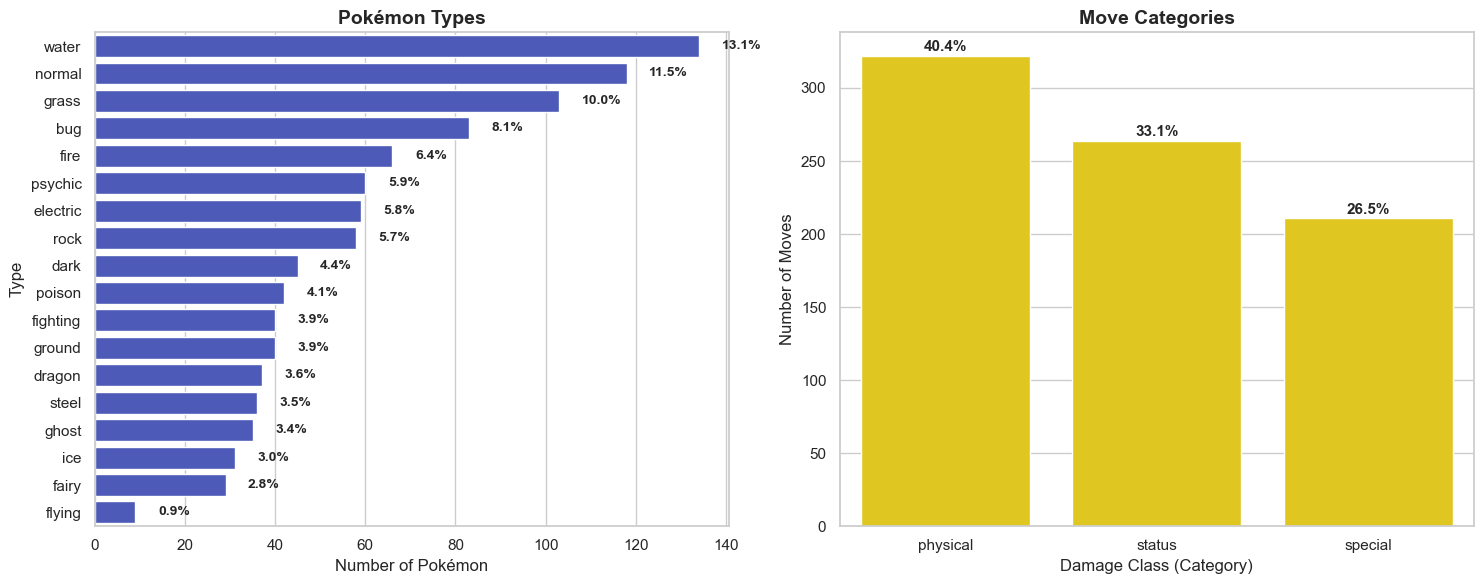


Imbalance Ratio (Type): The most common type is 14.9x more frequent than the rarest.


In [5]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 6))

# Distribution of Pokémon Types (Type 1)
ax1 = plt.subplot(1, 2, 1)
type_counts = pokemon_df['type_1'].value_counts()
total_pokemon = len(pokemon_df)

sns.countplot(
    data=pokemon_df, 
    y='type_1', 
    order=type_counts.index, 
    color="#3B4CCA",
    ax=ax1
)

for container in ax1.containers:
    counts = [rect.get_width() for rect in container]
    for rect, count in zip(container, counts):
        pct = count / total_pokemon * 100
        ax1.text(count + 5, rect.get_y() + rect.get_height()/2, f"{pct:.1f}%", va='center', fontweight='bold', fontsize=10)

ax1.set_title('Pokémon Types', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Pokémon')
ax1.set_ylabel('Type')

# Distribution of Move Damage Classes (Damage Class)
ax2 = plt.subplot(1, 2, 2)
move_counts = moves_df['damage_class'].value_counts()
total_moves = len(moves_df)

sns.countplot(
    data=moves_df, 
    x='damage_class', 
    order=move_counts.index, 
    color="#FFDE00", 
    ax=ax2
)

for container in ax2.containers:
    counts = [rect.get_height() for rect in container]
    for rect, count in zip(container, counts):
        pct = count / total_moves * 100
        ax2.text(rect.get_x() + rect.get_width()/2, count + 3, f"{pct:.1f}%", ha='center', fontweight='bold', fontsize=11)

ax2.set_title('Move Categories', fontsize=14, fontweight='bold')
ax2.set_xlabel('Damage Class (Category)')
ax2.set_ylabel('Number of Moves')

plt.tight_layout()
plt.show()

# type ratio
type_ratio = type_counts.max() / type_counts.min()
print(f"\nImbalance Ratio (Type): The most common type is {type_ratio:.1f}x more frequent than the rarest.")

## **Part 2: Clustering Pokémon by Statistics** ##

### **2.1 Prepare Data** ###
To prepare data for clustering, normalize the features using **StandardScaler**.
This choice is motivated by the fact that clustering algorithms are based on distance calculations. StandardScaler transforms each feature to have a mean of 0 and a standard deviation of 1, ensuring that all variables contribute equally regardless of their original scale.
Compared to other methods, StandardScalar is **less sensitive** to extreme values and better **preserves the overall data distribution**.

In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 1. Select base statistics
stats_columns = ['hp', 'attack', 'defense', 'special-attack', 'special-defense', 'speed']
X = pokemon_df[stats_columns]

# 2. Data Normalization
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

# Create a new DataFrame with the normalized data for easier subsequent steps
df_scaled = pd.DataFrame(X_scaled, columns=stats_columns)

df_scaled.head()

hp    attack   defense  special-attack  special-defense     speed
0 -0.946139 -0.958141 -0.803046       -0.171400        -0.195515 -0.772957
1 -0.382612 -0.521431 -0.324785        0.334606         0.367837 -0.250367
2  0.368758  0.150432  0.358446        1.009281         1.118973  0.446419
3 -1.171550 -0.857362 -1.008015       -0.340069        -0.758867 -0.076171
4 -0.457749 -0.454244 -0.495592        0.334606        -0.195515  0.446419

### **2.2 Apply Clustering** ###
**K-Means** was chosen because of:
- **Nature of the data:** K-Means works efficiently with numerical data using Euclidean distance to measure similarity between Pokémon.
- **Discovery of archetypes:** The objective is to identify Pokémon “archetypes”. K-Means is effective at finding compact and well-defined clusters, which can represent these central archetypes in a multidimensional space.
- **Simplicity and interpretability:** K-Means is computationally efficient and easy to interpret. The centroids represent the average statistics of each cluster, which helps us describe and compare the groups.

Parameters tested in K-Means:
- **Number of clusters (k):** This is the most important parameter. Since the true number of groups is unknown, we tested values of k from 2 to 10.
The final choice was based on:
- **Elbow Method (Inertia):** To find the point where adding more clusters does not significantly improve the model.
- **Silhouette Score:** To evaluate how well-separated and compact clusters are.

Optimal choice of **$k=5$**:
- The **Silhouette Curve** shows a clear local maximum at $k=5$, indicating that with 5 clusters, the Pokémon are more "similar" to others in their own group and more "distinct" from those in other groups compared to $k=4$.
- The **Elbow Method** shows a significant decrease in the sum of squared distances up to $k=5$. While a small "elbow" starts at $k=4$, the improvement gained by moving to $k=5$ is statistically significant enough to justify the extra cluster.

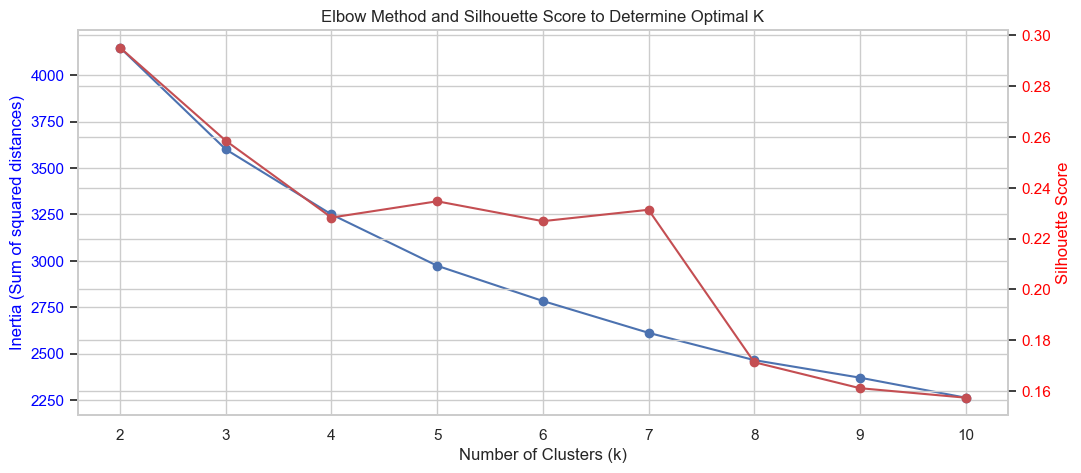

Clusters successfully assigned to 1025 Pokémon.


In [7]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Test different values of K (e.g., from 2 to 10) to find the optimal number of clusters
inertia = []
silhouette_avg = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_avg.append(silhouette_score(X_scaled, kmeans.labels_))

fig, ax1 = plt.subplots(figsize=(12, 5))

# Elbow Method
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia (Sum of squared distances)', color='blue')
ax1.plot(K_range, inertia, 'bo-', label='Inertia')
ax1.tick_params(axis='y', labelcolor='blue')

# Silhouette Score
ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score', color='red')
ax2.plot(K_range, silhouette_avg, 'ro-', label='Silhouette Score')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Elbow Method and Silhouette Score to Determine Optimal K')
plt.show()

# Based oon the plots, choose the optimal number of clusters
n_clusters_chosen = 5

kmeans_final = KMeans(n_clusters=n_clusters_chosen, random_state=42, n_init=10)
# n_init: how many times the k-means algorithm will be run with different centroid seeds
pokemon_df['cluster'] = kmeans_final.fit_predict(X_scaled)

print(f"Clusters successfully assigned to {len(pokemon_df)} Pokémon.")

### **2.3 Visualize the Clusters** ###
We chose **PCA (Principal Component Analysis)** to visualize the clustering results because the Pokémon dataset is six-dimensional (HP, Attack, Defense, Special Attack, Special Defense, and Speed). 
- PCA projects this high-dimensional data into a two-dimensional space while preserving as much variance and global structure as possible.
- The resulting components are easy to interpret, often reflecting overall power and the contrast between offensive and defensive stats. 
- PCA is also well suited for K-Means since both rely on Euclidean distance, allowing a faithful visualization of cluster separation without the distortions introduced by non-linear methods.
- Finally, PCA is computationally efficient and does not require complex hyperparameter tuning, making it a reliable and reproducible choice.

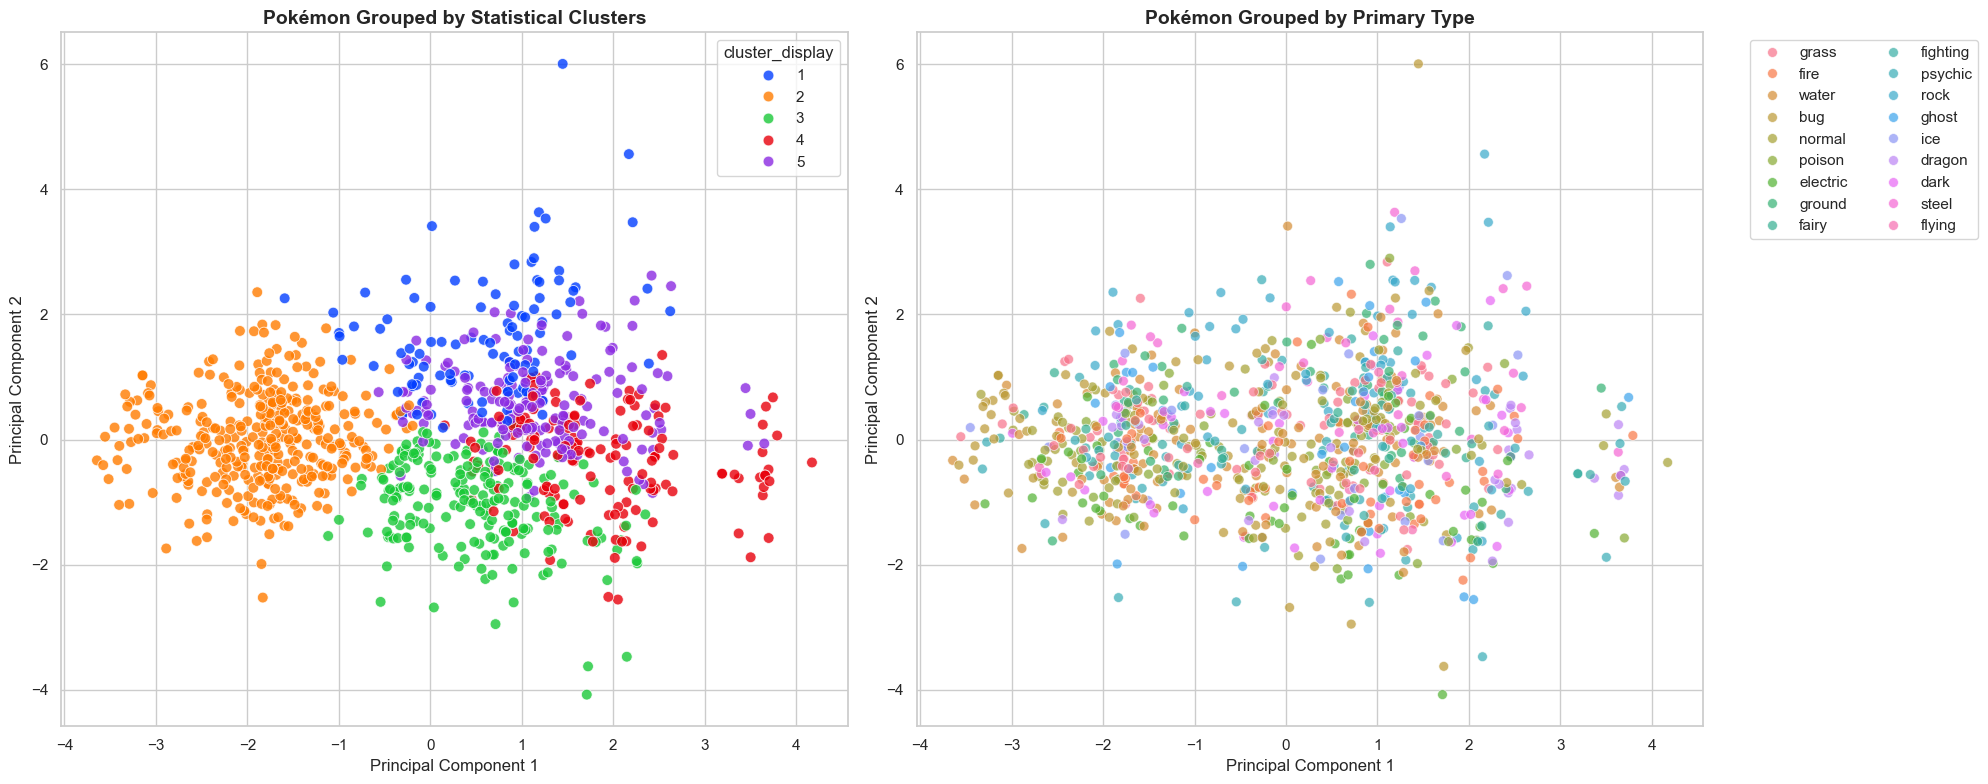

Total variance explained by the first two components: 62.50%


In [8]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Apply PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
pca_results = pca.fit_transform(X_scaled)

pokemon_df['pca_1'] = pca_results[:, 0]
pokemon_df['pca_2'] = pca_results[:, 1]

# 2. Creating subplots for side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

pokemon_df['cluster_display'] = pokemon_df['cluster'] + 1

# Plot 1: Colored by Cluster (the archetypes)
sns.scatterplot(
    x='pca_1', y='pca_2', 
    hue='cluster_display', 
    data=pokemon_df, 
    palette='bright',
    ax=ax1, 
    s=60,
    alpha=0.8,
    edgecolor='w'
)
ax1.set_title('Pokémon Grouped by Statistical Clusters', fontsize=14, fontweight='bold')
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')

# Plot 2: Colored by Primary Type for comparison
sns.scatterplot(
    x='pca_1', y='pca_2', 
    hue='type_1', 
    data=pokemon_df, 
    ax=ax2, 
    s=50,
    alpha=0.7,
    edgecolor='w'
)
ax2.set_title('Pokémon Grouped by Primary Type', fontsize=14, fontweight='bold')
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

print(f"Total variance explained by the first two components: {pca.explained_variance_ratio_.sum():.2%}")

### **2.4 Interpret the Clusters** ###
- **Archetype 1 - Basic & Early-Stage Pokémon:** Lowest average total stats (~300), with values around 50 in most attributes. Represents unevolved or early-game Pokémon with no clear specialization and generally weak overall performance.

- **Archetype 2 – Defensive Tanks:** Very high Defense and Special Defense, but the lowest Speed. These Pokémon act as “walls,” designed to absorb damage rather than attack quickly. 

- **Archetype 3 – Fast Sweepers:** Highest Speed and balanced offensive stats. Offensive Pokémon that rely on speed to strike first and defeat opponents, with moderate defenses.

-  **Archetype 4 – Bulky Physical Attackers:** Highest HP and Physical Attack. Strong and resilient fighters that deal heavy physical damage while withstanding hits.

- **Archetype 5 – Elite Special Specialists:** Highest overall average stats, with excellent Special Attack and Special Defense. Likely includes legendary or final-evolution Pokémon, specialized in special moves and highly powerful overall.


In [17]:
stats_columns = ['hp', 'attack', 'defense', 'special-attack', 'special-defense', 'speed']

# Define descriptive name for the 5 clusters
cluster_names = {
    1: "Defensive Walls & Tanks",
    2: "Basic & Early-Stage Pokémon",
    3: "Fast Sweeperss",
    4: "Special Specialists",
    5: "Bulky Physical Attackerss"
}

pokemon_df['archetype'] = pokemon_df['cluster_display'].map(cluster_names)

# Compute the average statistics for each archetype
cluster_interpretation = pokemon_df.groupby('archetype')[stats_columns].mean()

cluster_interpretation['count'] = pokemon_df['archetype'].value_counts()
cluster_interpretation['total_stat_avg'] = cluster_interpretation[stats_columns].sum(axis=1)

print("Average Statistics per Archetype:")
display(cluster_interpretation.sort_values(by='total_stat_avg').round(2))

Average Statistics per Archetype:


hp  attack  defense  special-attack  \
archetype                                                              
Basic & Early-Stage Pokémon   49.98   53.58    50.46           48.32   
Defensive Walls & Tanks       64.27   80.90   120.23           62.59   
Fast Sweeperss                68.76   86.41    65.42           82.07   
Bulky Physical Attackerss    100.14  109.69    86.14           68.42   
Special Specialists           88.39   81.91    86.25          112.03   

                             special-defense  speed  count  total_stat_avg  
archetype                                                                   
Basic & Early-Stage Pokémon            48.60  49.52    369          300.46  
Defensive Walls & Tanks                89.19  46.71    104          463.89  
Fast Sweeperss                         69.19  98.64    211          470.49  
Bulky Physical Attackerss              75.13  65.15    184          504.67  
Special Specialists                   104.01  82.39    157          554.98

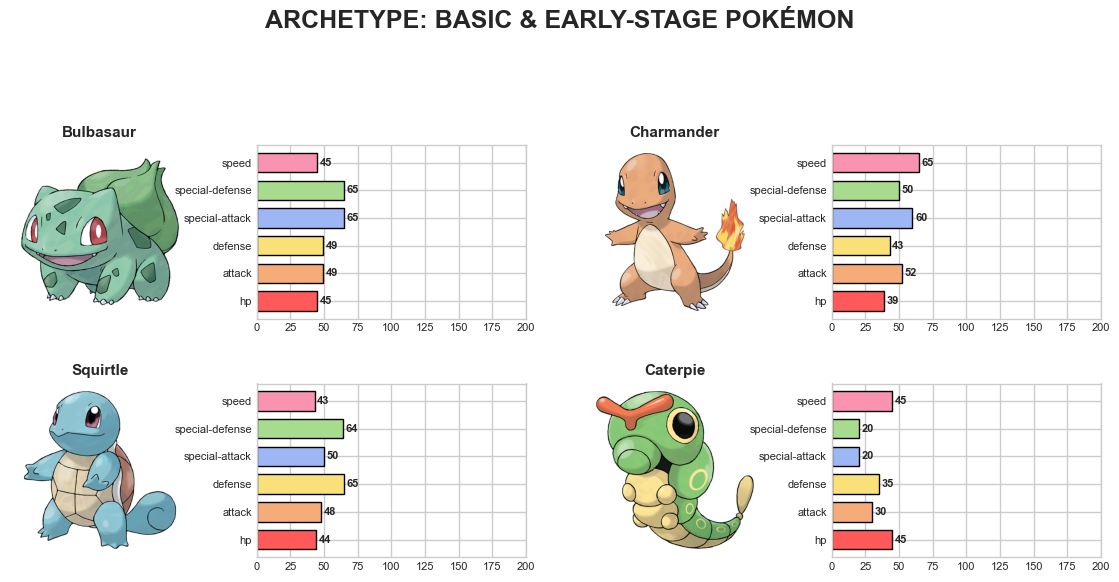

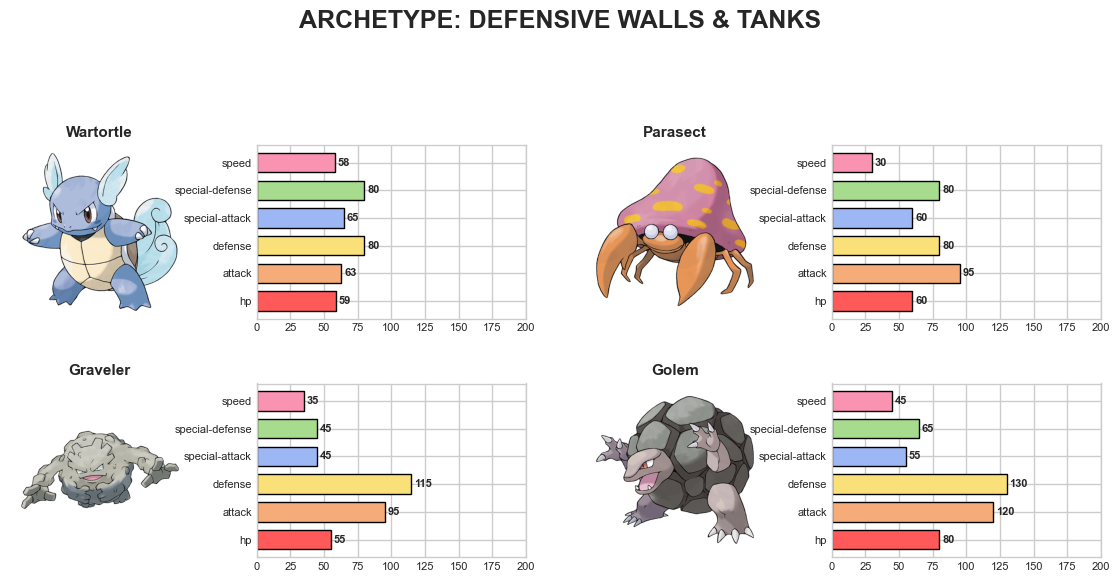

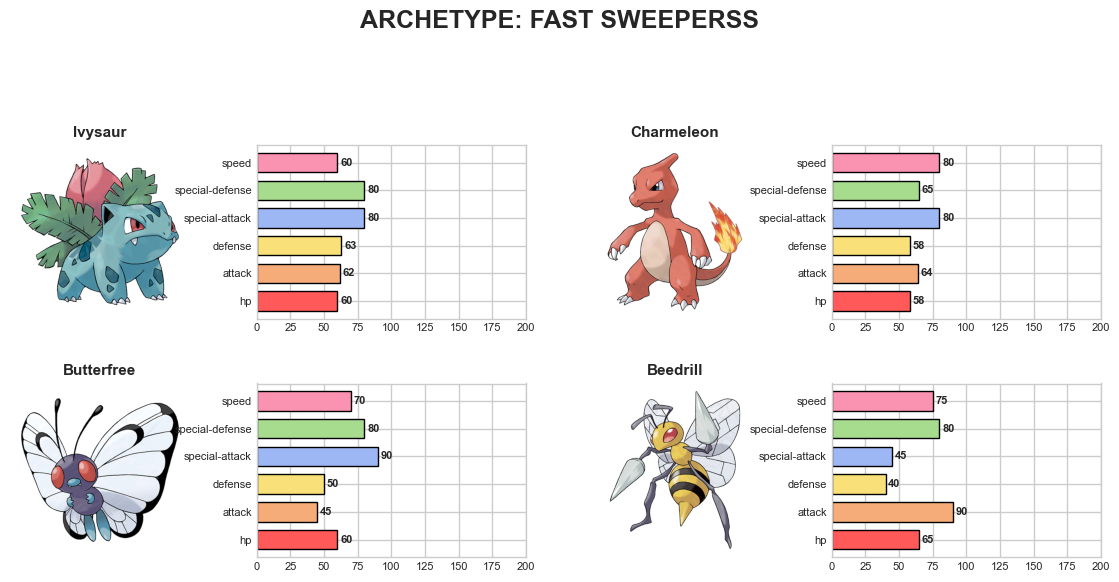

In [53]:
import requests
import matplotlib.pyplot as plt
from PIL import Image as PILImage
from io import BytesIO

def get_pokemon_image_pil(name):
    try:
        name_clean = name.lower().replace(" ", "-").replace(".", "").replace("'", "")
        url = f"https://pokeapi.co/api/v2/pokemon/{name_clean}"
        response = requests.get(url, timeout=5)
        if response.status_code == 200:
            img_url = response.json()['sprites']['other']['official-artwork']['front_default']
            img_response = requests.get(img_url)
            return PILImage.open(BytesIO(img_response.content))
    except:
        return None

stats_colors = ['#FF5959', '#F5AC78', '#FAE078', '#9DB7F5', '#A7DB8D', '#FA92B2']

# Iterate through each cluster archetype
for archetype, group in pokemon_df.groupby('archetype'):
    samples = group.head(4)
    num_samples = len(samples)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 6))
    fig.suptitle(f"ARCHETYPE: {archetype.upper()}", fontsize=18, fontweight='bold', y=1.02)
    
    axes_flat = axes.flatten()

    for i in range(4):
        ax = axes_flat[i]
        
        if i < num_samples:
            pkmn = samples.iloc[i]
            pkmn_name = pkmn['name']
            stats_values = [pkmn[col] for col in stats_columns]
            
            inner_grid = ax.get_subplotspec().subgridspec(1, 2, wspace=0.3, width_ratios=[1, 1.5])
            ax_img = fig.add_subplot(inner_grid[0])
            ax_bar = fig.add_subplot(inner_grid[1])
            
            # 1. Image handling 
            img = get_pokemon_image_pil(pkmn_name)
            if img:
                ax_img.imshow(img)
            ax_img.set_title(f"{pkmn_name.capitalize()}", fontsize=11, fontweight='bold')
            ax_img.axis('off')
            
            # 2. Stats bar chart 
            bars = ax_bar.barh(stats_columns, stats_values, color=stats_colors, edgecolor='black', height=0.7)
            ax_bar.set_xlim(0, 200) # Standardized scale for better comparison
            ax_bar.tick_params(axis='both', which='major', labelsize=8)
            
            for bar in bars:
                width = bar.get_width()
                ax_bar.text(width + 2, bar.get_y() + bar.get_height()/2, f'{int(width)}', 
                            va='center', fontsize=8, fontweight='bold')
            
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout(pad=3.0)
    plt.show()

#### **Do the clusters correspond to official Pokémon types?** ####

No, the clusters do not match the official Pokémon types (such as Fire, Water, or Grass). Instead, they group Pokémon by their statistical roles and battle behavior.
For example, in the **Fast Sweepers** cluster we find Pokémon of different types such as **Ivysaur** (Grass), **Charmeleon** (Fire), and **Pidgeot** (Normal). This shows that clustering is driven by numerical stats (Speed, Attack, Defense) rather than elemental type.

#### **Are there Pokémon that seem misplaced? Why might this happen?** ####

Some Pokémon may appear unuasual in their clusters because of specific traits:
- **Wigglytuff** appears among **Bulky Physical Attackers** mainly due to its very high HP (140), even though its Attack is not extremely high (70).
- Intermediate evolution forms such as **Wartortle** and **Charmeleon** fall between basic and fully evolved Pokémon and are therefore assigned to middle clusters like **Defensive Walls** or **Fast Sweepers**.
- Pokémon with one dominant stat (for example very high Defense or HP like **Golem** or **Slowbro**) are grouped according to that strenght, even if other stats are more balanced.

#### **Do Pokémon naturally group into distinct “archetypes” based on their statistics?** ####

Yes, Pokémon naturally group into distinct statistical archetypes.
The 5 clusters do not correspond to elemntal types but instead represent **functional roles**. The PCA visualization shows that these clusters are compact and well separated, while Pokémon grouped by type are widely scattered.

## **Part 3: Analyzing Moves with Text** ##


### **3.1 Apply TF-IDF to Move Description** ###
- **TF-IDF (Term Frequency - Inverse Document Frequency)** is a technique used in text analysis to measure how important a word is to the drscription of a single move, within the entire list of all Pokémon move descriptions.
- By applying TD-IDF, we can find the **Characteristics Words** for each category (Physical, Status, Special).

In [22]:
import pandas as pd
import string
from sklearn.feature_extraction.text import TfidfVectorizer

moves_df = pd.read_csv('moves_complete.csv')

# Text Preprocessing Function
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = text.lower() #convert to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
    text = " ".join(text.split()) # remove extra spaces
    return text

# Apply the cleaning function to the effect_text column
moves_df['clean_effect_text'] = moves_df['effect_text'].apply(preprocess_text)

# Compute TF-IDF Vectors
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Compute the TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(moves_df['clean_effect_text'])

print(f"TF-IDF Matrix Dimensions: {tfidf_matrix.shape}")
print(f"Total Moves Analyzed: {tfidf_matrix.shape[0]}")
print(f"Unique words in vocabulary: {tfidf_matrix.shape[1]}")

TF-IDF Matrix Dimensions: (797, 1115)
Total Moves Analyzed: 797
Unique words in vocabulary: 1115


### **3.2 Find Characteristic Words** ###
To identify the unique vocabolary of different moves types, calcualte the average TF-IDF scores for all words within the three damage categories: Physical, Special and Status.
- **Physical and Special** moves share similar dominant words such as “damage”, “inflicts”, and “chance”, reflecting their main role of dealing direct damage.
- **Status moves** show a different pattern. Their top words focus on strategy rather than damage, with words like: "raisers", "lowers", "target"...

The TF-IDF analysis captures the functional identity of each move class: Physical and Special moves are attack-oriented, while Status moves are defined by their abiloity to modify and control the battle.

In [23]:
import pandas as pd
import numpy as np

# Retrieve feature names (words) from the vectorizer
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

# Create a dataframe from the TF-IDF matrix and add the damage_class column
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
tfidf_df['damage_class'] = moves_df['damage_class']

# Extract the top N characteristic words for each group
def get_top_tfidf_words(group, top_n=10):
    mean_weights = group.drop(columns=['damage_class']).mean(axis=0)
    top_indices = mean_weights.argsort()[-top_n:][::-1]
    return pd.Series({feature_names[i]: round(mean_weights[i], 4) for i in top_indices})

# Apply the function to each damage class (physical, special, status)
top_words_by_class = tfidf_df.groupby('damage_class').apply(get_top_tfidf_words).T

print("Top 10 Characteristic Words per Damage Class (Highest Mean TF-IDF):")
display(top_words_by_class)

Top 10 Characteristic Words per Damage Class (Highest Mean TF-IDF):


damage_class              
physical      inflicts        0.1855
              damage          0.1855
              regular         0.1824
              target          0.0767
              chance          0.0739
              effectchance    0.0649
              user            0.0579
              hit             0.0443
              turn            0.0394
              stage           0.0381
special       damage          0.1743
              inflicts        0.1662
              regular         0.1653
              effectchance    0.1109
              chance          0.1070
              target          0.0957
              lower           0.0612
              stage           0.0584
              user            0.0516
              special         0.0470
status        target          0.0912
              user            0.0886
              attack          0.0708
              raises          0.0702
              stage           0.0605
              lowers          0.0581
           

### **3.3 Cluster The Moves** ###
By examining the moves grouped within the same cluster, clear functional patterns emerged:
- **Cluster 1** mainly contains physical moves that deal regular damage without any additional effects, such as *Cut*, *Tackle*, and *Vine Whip*. These moves represent simple and direct attacks with straightforward mechanics.

- **Cluster 2** is dominated by status moves and includes actions like *Swords Dance*, *Growl*, and *Double Team*. These moves focus on modifying statistics by raising the user’s attributes or lowering the opponent’s, showing a clearly strategic and non-damaging role.

- **Cluster 3** groups moves with more complex mechanics, such as requiring a charging turn or involving recoil and continuous effects. Examples like *Solar Beam*, *Take Down*, and *Leech Seedé* show that this cluster captures attacks with special conditions and more elaborate behaviors compared to basic damage moves.

- **Cluster 4** is mainly composed of special attacks that include a probability of producing secondary effects, such as flinching or inflicting status conditions. Moves like *Sludge Bomb* and *Energy Ball* illustrate how this group combines offensive power with tactical side effects.

In [24]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Apply k-means to TF-IDF matrix 
K_range = range(2, 11)
inertia = []
silhouette_vals = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(tfidf_matrix)
    inertia.append(kmeans.inertia_)
    silhouette_vals.append(silhouette_score(tfidf_matrix, kmeans.labels_))

fig, ax1 = plt.subplots(figsize=(12, 5))

# Elbow Method Plot
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia (Sum of squared distances)', color='tab:blue')
ax1.plot(K_range, inertia, 'o-', color='tab:blue', label='Inertia')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Plot Silhouette Score
ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score', color='tab:red')
ax2.plot(K_range, silhouette_vals, 's-', color='tab:red', label='Silhouette')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Elbow Method and Silhouette Score for TF-IDF Move Vectors')
plt.show()

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Choose an appropriate number of clusters based on previous analysis
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
moves_df['cluster'] = kmeans.fit_predict(tfidf_matrix) + 1

# Dimensionality Reduction for Visualization (PCA)
# transform the TF-IDF matrix (1115 features) into 2 components for plotting
pca = PCA(n_components=2, random_state=42)
pca_results = pca.fit_transform(tfidf_matrix.toarray())
moves_df['pca_1'] = pca_results[:, 0]
moves_df['pca_2'] = pca_results[:, 1]

# Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='pca_1', y='pca_2', 
    hue='cluster', 
    data=moves_df, 
    palette='bright', 
    s=60, alpha=0.7
)
plt.title(f'Move Cluster Visualization (k={optimal_k}) via PCA', fontsize=15)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Cluster Content Analysis
print(f"Analysis of the {optimal_k} clusters:")
for i in range(1, optimal_k + 1):
    print(f"\nCLUSTER {i}:")
    cluster_data = moves_df[moves_df['cluster'] == i]
    
    # Cluster size and dominant damage class
    count = len(cluster_data)
    top_damage = cluster_data['damage_class'].value_counts().idxmax()
    
    print(f"Number of moves: {count}")
    print(f"Dominant Damage Class: {top_damage}")
    print("Move Examples:")
    print(cluster_data['name'].head(8).tolist())
    print("Sample Description:", cluster_data['short_effect_text'].iloc[0])


Analysis of the 4 clusters:

CLUSTER 1:
Number of moves: 69
Dominant Damage Class: physical
Move Examples:
['cut', 'vine-whip', 'tackle', 'strength', 'seed-bomb', 'power-whip', 'grassy-glide', 'petal-blizzard']
Sample Description: Inflicts regular damage with no additional effect.

CLUSTER 2:
Number of moves: 92
Dominant Damage Class: status
Move Examples:
['swords-dance', 'growl', 'growth', 'string-shot', 'rage', 'double-team', 'amnesia', 'flash']
Sample Description: Raises the user’s Attack by two stages.

CLUSTER 3:
Number of moves: 516
Dominant Damage Class: physical
Move Examples:
['razor-wind', 'bind', 'take-down', 'double-edge', 'mega-drain', 'leech-seed', 'razor-leaf', 'solar-beam']
Sample Description: Requires a turn to charge before attacking.

CLUSTER 4:
Number of moves: 120
Dominant Damage Class: special
Move Examples:
['headbutt', 'body-slam', 'sludge', 'snore', 'sludge-bomb', 'mud-slap', 'rock-smash', 'energy-ball']
Sample Description: Has a $effect_chance% chance to make

In [26]:
# Cluster purity
cluster_purity = pd.crosstab(moves_df['cluster'], moves_df['damage_class'])
print("Cluster Composition by Damage Class")
print(cluster_purity)

Cluster Composition by Damage Class
damage_class  physical  special  status
cluster                                
1                   47       19       3
2                   17        9      66
3                  202      120     194
4                   56       63       1


In [27]:
# Check cluster 1 composition
unique_desc = moves_df[moves_df['cluster'] == 1]['short_effect_text'].nunique()
print(f"Number of unique descriptions in Cluster 1: {unique_desc}")

Number of unique descriptions in Cluster 1: 2


#### **Do the text-based clusters align with the official categories (physical/special/status)?** ####
The clusters align only partially with the official categories. Status moves form a very clear and pure cluster because they use a unique vocabulary related to stat changes.
**Physical and Special moves** often appear together in the same clusters because their **descriptions are similar**, focusing on dealing damage and having secondary effects.

#### **What patterns do you find?** ####
- **Vanilla pattern:** Simple physical moves with descriptions like “inflicts regular damage” group tightly together.
- **Chance pattern:** Moves with a probability of secondary effects (e.g., flinch or burn) cluster together, regardless of being Physical or Special.
- **Strategic pattern:** Status moves are identified by keywords such as “raises”, “lowers”, and “stages”.
- **Complexity pattern:** Moves with longer and more complex descriptions (charging turns, recoil, special conditions) form a mixed cluster including all damage classes.

#### **What can we learn from the text descriptions of moves that we cannot see from the numeric attributes?** ####
**Text descriptions explain how a move works in battle**, not just how strong it is.
They capture mechanics such as stat changes, secondary effects, and special conditions (e.g., charging or recoil), allowing moves to be grouped by their functional role rather than only by power or accuracy.

## **Part 4: Connecting Pokémon and Moves** ##

### **4.1 Create a  move-based representation of Pokémon** ###
Each Pokémon is described by:
- **Average move power**
- **Average move accuracy**
- **Number of Physical, Special and Status moves**

The columns *avg_move_power* and *avg_move_accuracy* describe the **general quality** of a Pokémon's moves. For example, Pokémon 3 has a higher average power than Pokémon 1 and 2, indicating a more offensive move pool.

The counts of Physical, Special, and Status moves describe the Pokémon’s battle role:
- Pokémon with many Status moves (e.g., Pokémon 3) may have more tactical or support-oriented behavior.
- Pokémon with many Physical moves (e.g., Pokémon 4 and 5) appear more focused on physical attacking.


In [28]:
# 1. Merge Data: Link Pokémon learnsets with move details
moves_info = learnset_df.merge(moves_df, on='move_id', how='left')

# 2. Statistical Aggregation
move_stats_summary = moves_info.groupby('pokemon_id').agg({
    'power': 'mean',
    'accuracy': 'mean'
}).rename(columns={'power': 'avg_move_power', 'accuracy': 'avg_move_accuracy'})

# 3. Damage Class Distribution (Categorical Representation)
damage_class_counts = pd.get_dummies(moves_info[['pokemon_id', 'damage_class']], columns=['damage_class'])
damage_class_summary = damage_class_counts.groupby('pokemon_id').sum()

pokemon_moves_rep = move_stats_summary.join(damage_class_summary).fillna(0)

print("Move-Based Representation of Pokémon (First 5 rows):")
print(pokemon_moves_rep.head())

Move-Based Representation of Pokémon (First 5 rows):
            avg_move_power  avg_move_accuracy  damage_class_physical  \
pokemon_id                                                             
1                67.954545          96.639344                     28   
2                66.219512          97.192982                     27   
3                73.076923          97.028986                     34   
4                72.397059          95.000000                     53   
5                72.772727          94.938272                     52   

            damage_class_special  damage_class_status  
pokemon_id                                             
1                             21                   37  
2                             19                   37  
3                             23                   39  
4                             24                   28  
5                             23                   28  


### **4.2 Compare similarity structures** ###
Use **Euclidean Distance** on **standardized data** to find te nearest pokémon in two different space: the **Stat space** and the **Move space**.

Visual Similarity Comparison: Statistics vs. Move Representation


------------------------------------------------------------------------------------------------------------------------


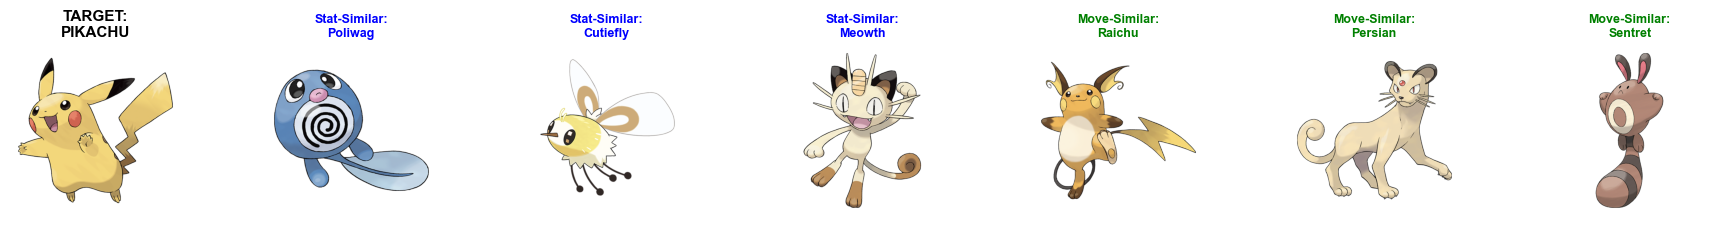

------------------------------------------------------------------------------------------------------------------------


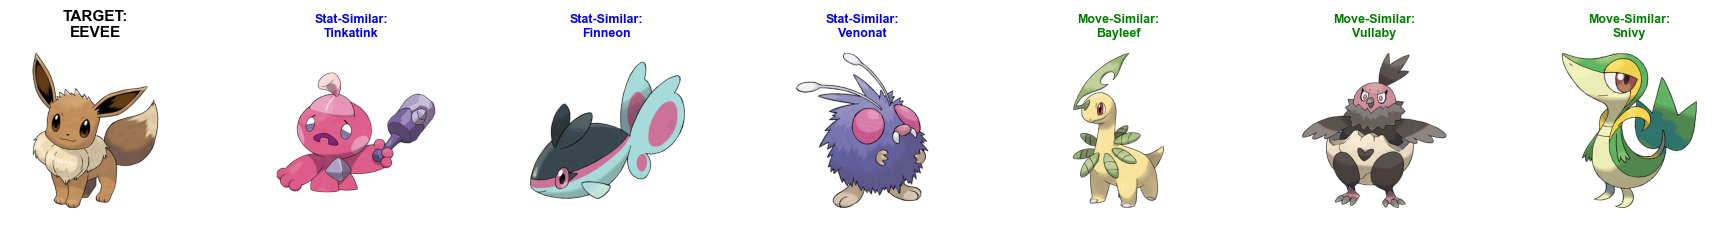

------------------------------------------------------------------------------------------------------------------------


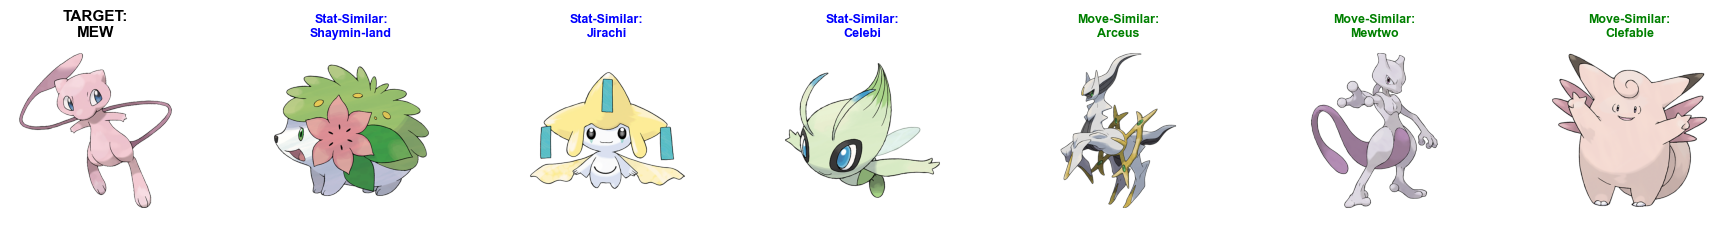

------------------------------------------------------------------------------------------------------------------------


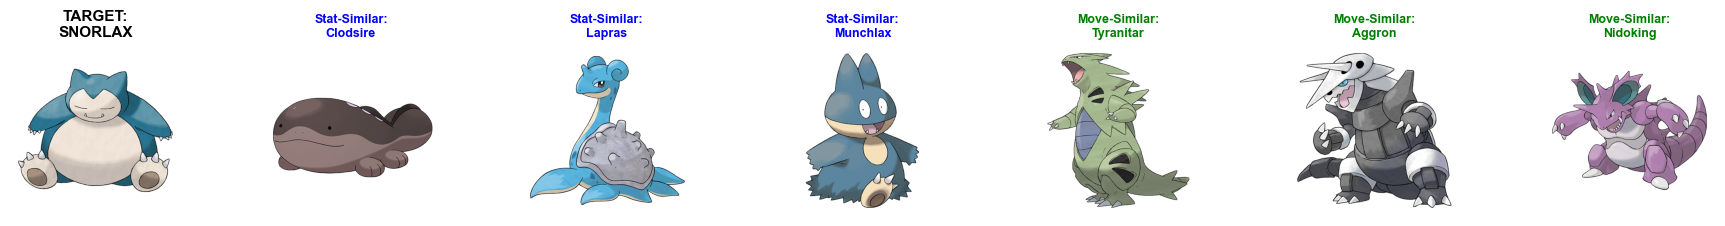

------------------------------------------------------------------------------------------------------------------------


In [54]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from PIL import Image as PILImage
from io import BytesIO

# --- 1. DATA PREPARATION & CLEANING ---
stats_data.index = pd.to_numeric(stats_data.index)
pokemon_moves_rep.index = pd.to_numeric(pokemon_moves_rep.index)

# Standardizing the features for distance calculation
scaler = StandardScaler()
stats_scaled = scaler.fit_transform(stats_data)
moves_scaled = scaler.fit_transform(pokemon_moves_rep)

pokemon_names = pokemon_df.set_index('pokemon_id')['name'].to_dict()

def get_pokemon_img(name):
    try:
        name_clean = name.lower().replace(" ", "-").replace(".", "").replace("'", "")
        url = f"https://pokeapi.co/api/v2/pokemon/{name_clean}"
        response = requests.get(url, timeout=5).json()
        img_url = response['sprites']['other']['official-artwork']['front_default']
        return PILImage.open(BytesIO(requests.get(img_url).content))
    except:
        return None

# --- 2. TARGET SELECTION ---
target_ids = [1, 25, 133, 151, 143]

print("Visual Similarity Comparison: Statistics vs. Move Representation")
print("=" * 100)

# --- 3. SIMILARITY ANALYSIS & VISUALIZATION ---
for p_id in target_ids:
    if p_id not in stats_data.index or p_id not in pokemon_moves_rep.index:
        continue

    try:
        p_name = pokemon_names[p_id]
        
        # Get positional indices for distance matrices
        idx_stats = stats_data.index.get_loc(p_id)
        idx_moves = pokemon_moves_rep.index.get_loc(p_id)
        
        # Calculate Euclidean Similarity by Stats
        dist_stats = pairwise_distances(stats_scaled[idx_stats].reshape(1, -1), stats_scaled).flatten()
        all_stats_indices = stats_data.index[dist_stats.argsort()]
        filtered_stats_indices = [i for i in all_stats_indices if i != p_id][:3] 
        closest_stats_names = [pokemon_names[i] for i in filtered_stats_indices]
        
        # Calculate Euclidean Similarity by Moves
        dist_moves = pairwise_distances(moves_scaled[idx_moves].reshape(1, -1), moves_scaled).flatten()
        all_moves_indices = pokemon_moves_rep.index[dist_moves.argsort()]
        filtered_moves_indices = [i for i in all_moves_indices if i != p_id][:3]
        closest_moves_names = [pokemon_names[i] for i in filtered_moves_indices]
            
        # --- PLOTTING ---
        fig, axes = plt.subplots(1, 7, figsize=(22, 5))
        plt.subplots_adjust(wspace=0.5)
        
        target_img = get_pokemon_img(p_name)
        if target_img: axes[0].imshow(target_img)
        axes[0].set_title(f"TARGET:\n{p_name.upper()}", fontweight='bold', color='black', fontsize=11)
        axes[0].axis('off')

        for i, sim_name in enumerate(closest_stats_names):
            img = get_pokemon_img(sim_name)
            if img: axes[i+1].imshow(img)
            axes[i+1].set_title(f"Stat-Similar:\n{sim_name.capitalize()}", fontweight='bold', color='blue', fontsize=9)
            axes[i+1].axis('off')

        for i, sim_name in enumerate(closest_moves_names):
            img = get_pokemon_img(sim_name)
            if img: axes[i+4].imshow(img)
            axes[i+4].set_title(f"Move-Similar:\n{sim_name.capitalize()}", fontweight='bold', color='green', fontsize=9)
            axes[i+4].axis('off')

        plt.show()
        print("-" * 120)
        
    except Exception as e:
        print(f"Error processing {p_name} (ID: {p_id}): {e}")

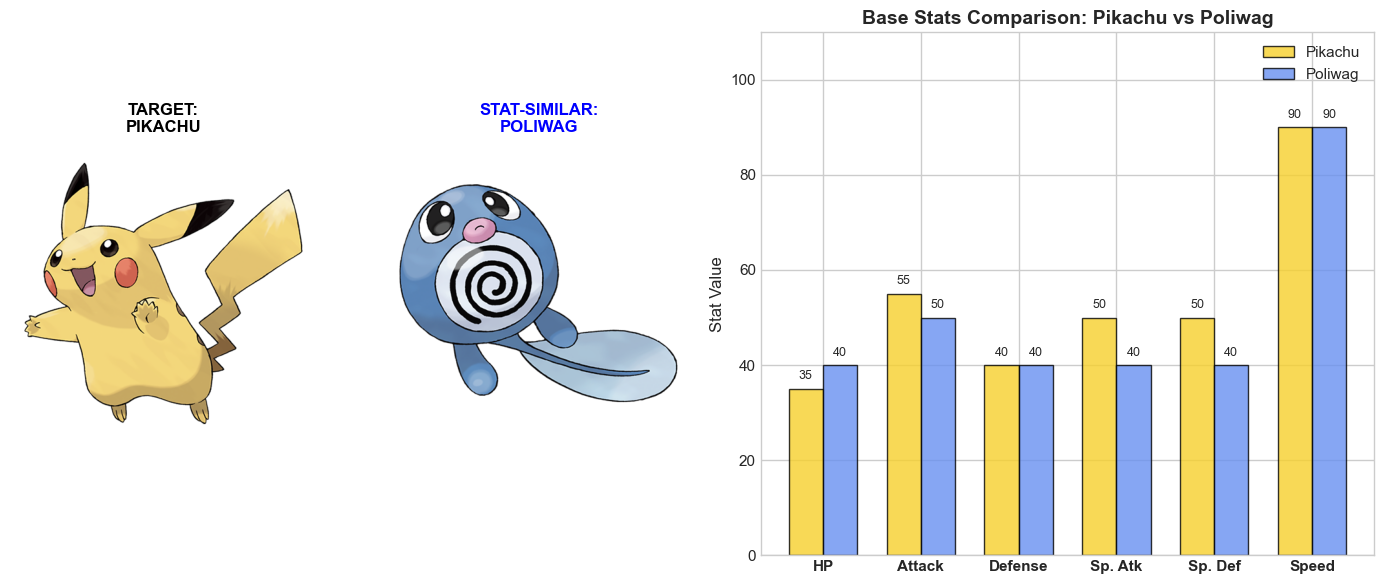

In [55]:
import requests
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as PILImage
from io import BytesIO

plt.style.use('seaborn-v0_8-whitegrid')
stats_labels = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
stats_cols = ['hp', 'attack', 'defense', 'special-attack', 'special-defense', 'speed']

def get_pokemon_img(name):
    try:
        name_clean = name.lower().replace(" ", "-").replace(".", "").replace("'", "")
        url = f"https://pokeapi.co/api/v2/pokemon/{name_clean}"
        response = requests.get(url, timeout=5).json()
        img_url = response['sprites']['other']['official-artwork']['front_default']
        return PILImage.open(BytesIO(requests.get(img_url).content))
    except: return None

# --- 2. DATA EXTRACTION ---
pika_stats = stats_data.loc[25].values
poliwag_stats = stats_data.loc[60].values

# --- 3. VISUALIZATION ---
fig = plt.figure(figsize=(14, 6))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 2])

ax_img1 = fig.add_subplot(gs[0])
ax_img2 = fig.add_subplot(gs[1])
ax_plot = fig.add_subplot(gs[2])

img_pika = get_pokemon_img("pikachu")
img_poli = get_pokemon_img("poliwag")

if img_pika: ax_img1.imshow(img_pika)
ax_img1.set_title("TARGET:\nPIKACHU", fontweight='bold', color='black')
ax_img1.axis('off')

if img_poli: ax_img2.imshow(img_poli)
ax_img2.set_title("STAT-SIMILAR:\nPOLIWAG", fontweight='bold', color='blue')
ax_img2.axis('off')

x = np.arange(len(stats_labels))
width = 0.35

ax_plot.bar(x - width/2, pika_stats, width, label='Pikachu', color='#F7D02C', edgecolor='black', alpha=0.8)
ax_plot.bar(x + width/2, poliwag_stats, width, label='Poliwag', color='#6890F0', edgecolor='black', alpha=0.8)

ax_plot.set_title('Base Stats Comparison: Pikachu vs Poliwag', fontweight='bold', fontsize=14)
ax_plot.set_ylabel('Stat Value')
ax_plot.set_ylim(0, 110) # Fixed scale to see the balance
ax_plot.set_xticks(x)
ax_plot.set_xticklabels(stats_labels, fontweight='bold')
ax_plot.legend()

for i in range(len(x)):
    ax_plot.text(x[i] - width/2, pika_stats[i] + 2, str(int(pika_stats[i])), ha='center', fontsize=9)
    ax_plot.text(x[i] + width/2, poliwag_stats[i] + 2, str(int(poliwag_stats[i])), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

In [56]:
import requests
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as PILImage
from io import BytesIO

# --- 1. SETTINGS & STYLING ---
plt.style.use('seaborn-v0_8-whitegrid')
move_labels = ['Physical', 'Special', 'Status']
move_cols = ['damage_class_physical', 'damage_class_special', 'damage_class_status']

def get_pokemon_img(name):
    try:
        name_clean = name.lower().replace(" ", "-").replace(".", "").replace("'", "")
        url = f"https://pokeapi.co/api/v2/pokemon/{name_clean}"
        response = requests.get(url, timeout=5).json()
        img_url = response['sprites']['other']['official-artwork']['front_default']
        return PILImage.open(BytesIO(requests.get(img_url).content))
    except: return None

# --- 2. DATA EXTRACTION ---
pika_moves = pokemon_moves_rep.loc[25][move_cols].values
raichu_moves = pokemon_moves_rep.loc[26][move_cols].values

# --- 3. VISUALIZATION ---
fig = plt.figure(figsize=(14, 6))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 2])

# Ax images
ax_img1 = fig.add_subplot(gs[0])
ax_img2 = fig.add_subplot(gs[1])
ax_plot = fig.add_subplot(gs[2])

img_pika = get_pokemon_img("pikachu")
img_raichu = get_pokemon_img("raichu")

if img_pika: ax_img1.imshow(img_pika)
ax_img1.set_title("TARGET:\nPIKACHU", fontweight='bold', color='black')
ax_img1.axis('off')

if img_raichu: ax_img2.imshow(img_raichu)
ax_img2.set_title("MOVE-SIMILAR:\nRAICHU", fontweight='bold', color='green')
ax_img2.axis('off')

# Plot comparison
x = np.arange(len(move_labels))
width = 0.35

ax_plot.bar(x - width/2, pika_moves, width, label='Pikachu', color='#F7D02C', edgecolor='black', alpha=0.8)
ax_plot.bar(x + width/2, raichu_moves, width, label='Raichu', color='#EE8329', edgecolor='black', alpha=0.8)

ax_plot.set_title('Move Pool Similarity: Evolution Comparison', fontweight='bold', fontsize=14)
ax_plot.set_ylabel('Number of Moves')
ax_plot.set_xticks(x)
ax_plot.set_xticklabels(move_labels, fontweight='bold')
ax_plot.legend()

for i, (p, r) in enumerate(zip(pika_moves, raichu_moves)):
    diff = abs(p - r)
    ax_plot.text(i, max(p, r) + 1, f'diff: {int(diff)}', ha='center', fontsize=10, style='italic', color='grey')

plt.tight_layout()
plt.show()

### **4.3 Analyze the relationship** ###

Structural Relationship Analysis: Visual Representatives


--------------------------------------------------------------------------------------------------------------


--------------------------------------------------------------------------------------------------------------


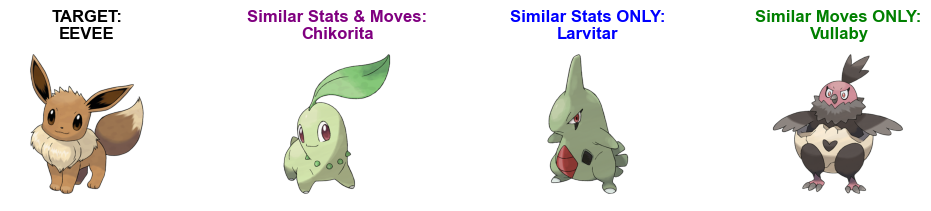

--------------------------------------------------------------------------------------------------------------


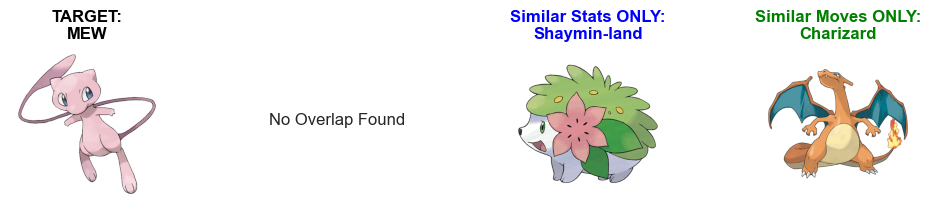

--------------------------------------------------------------------------------------------------------------


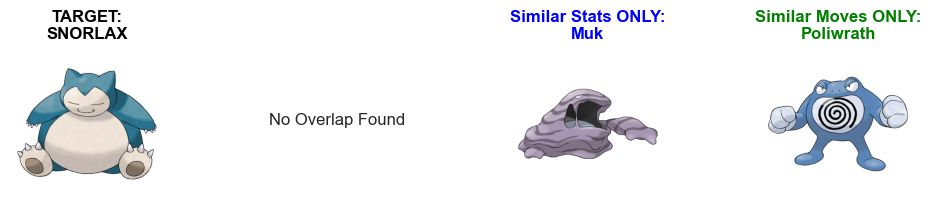

--------------------------------------------------------------------------------------------------------------


In [ ]:
import requests
import matplotlib.pyplot as plt
from PIL import Image as PILImage
from io import BytesIO

def get_pokemon_img(name):
    try:
        name_clean = name.lower().replace(" ", "-").replace(".", "").replace("'", "")
        url = f"https://pokeapi.co/api/v2/pokemon/{name_clean}"
        response = requests.get(url, timeout=5).json()
        img_url = response['sprites']['other']['official-artwork']['front_default']
        return PILImage.open(BytesIO(requests.get(img_url).content))
    except:
        return None

names_dict = pokemon_df.set_index('pokemon_id')['name'].to_dict()

print("Structural Relationship Analysis: Visual Representatives")
print("=" * 100)

for p_id in target_ids:
    if p_id not in stats_data.index or p_id not in pokemon_moves_rep.index:
        continue

    try:
        p_name = names_dict[p_id]
        idx = stats_data.index.get_loc(p_id)
        idx_moves = pokemon_moves_rep.index.get_loc(p_id)

        # 1. Calculate distances
        dist_s = pairwise_distances(stats_scaled[idx].reshape(1, -1), stats_scaled).flatten()
        dist_m = pairwise_distances(moves_scaled[idx_moves].reshape(1, -1), moves_scaled).flatten()

        # 2. Get Top 20 
        all_s_idx = stats_data.index[dist_s.argsort()]
        all_m_idx = pokemon_moves_rep.index[dist_m.argsort()]
        
        top_stats_ids = [i for i in all_s_idx if i != p_id][:20]
        top_moves_ids = [i for i in all_m_idx if i != p_id][:20]

        top_stats_names = set([names_dict[i] for i in top_stats_ids])
        top_moves_names = set([names_dict[i] for i in top_moves_ids])

        # 3. Define the 3 specific relationship cases
        # Case A: Intersection (Both)
        both = top_stats_names.intersection(top_moves_names)
        pkmn_both = list(both)[0] if both else None

        # Case B: Stats Similarity only (Different Moves)
        only_stats = top_stats_names.difference(top_moves_names)
        pkmn_only_stats = list(only_stats)[0] if only_stats else None

        # Case C: Moves Similarity only (Different Stats)
        only_moves = top_moves_names.difference(top_stats_names)
        pkmn_only_moves = list(only_moves)[0] if only_moves else None

        # --- VISUALIZATION ---
        fig, axes = plt.subplots(1, 4, figsize=(12, 2))
        plt.subplots_adjust(wspace=0.4)

        # Plot Target
        img_t = get_pokemon_img(p_name)
        if img_t: axes[0].imshow(img_t)
        axes[0].set_title(f"TARGET:\n{p_name.upper()}", fontweight='bold', color='black')
        axes[0].axis('off')

        # Plot Case A: Both
        if pkmn_both:
            img_a = get_pokemon_img(pkmn_both)
            if img_a: axes[1].imshow(img_a)
            axes[1].set_title(f"Similar Stats & Moves:\n{pkmn_both.capitalize()}", fontweight='bold', color='purple')
        else:
            axes[1].text(0.5, 0.5, "No Overlap Found", ha='center')
        axes[1].axis('off')

        # Plot Case B: Only Stats
        if pkmn_only_stats:
            img_b = get_pokemon_img(pkmn_only_stats)
            if img_b: axes[2].imshow(img_b)
            axes[2].set_title(f"Similar Stats ONLY:\n{pkmn_only_stats.capitalize()}", fontweight='bold', color='blue')
        axes[2].axis('off')

        # Plot Case C: Only Moves
        if pkmn_only_moves:
            img_c = get_pokemon_img(pkmn_only_moves)
            if img_c: axes[3].imshow(img_c)
            axes[3].set_title(f"Similar Moves ONLY:\n{pkmn_only_moves.capitalize()}", fontweight='bold', color='green')
        axes[3].axis('off')

        plt.show()
        print("-" * 110)

    except Exception as e:
        print(f"Error analyzing {p_id}: {e}")

#### **What does move similarity capture that stat similarity does not?** ####
Move similarity captures how a Pokémon behaves in battle, not just how strong it is.
- **Stats** describe physical potential (power, speed, defense)
- **Moves** describe fighting style and strategy (status effects, support roles, special mechanism)
Move similarity can group Pokémon into roles such as support, special attacker, or utility, even if their stats are very different.

#### **Which information would be more useful to describe a Pokémon?** ####
Both are important and complementary.
- **Stats** are useful to estimate strenght, speed and survivability.
- **Moves** are useful to understand strategy and versatility in battle.
A complete description of a Pokémon needs bothh perspectives.

#### **Are Pokémon that are similar in statistics also similar in the moves they can learn?** ####
Pokémon from the same evolutionary line are often similar in both stats and moves.
This shows that evolution usually preserves both physical structure and move patterns.
At the same time, Pokémon with similar stats can have different move pools.

# **Part 5: Finding Unusual Pokémon** #

### **5.1 Apply Anomaly Detection** ###
In the context of **Isolation Forest**, the anomlay score represents how easy is to isolate a specific data point.
In this case, we obtain negative scores, indicating that the Pokémon is highly unusual. 

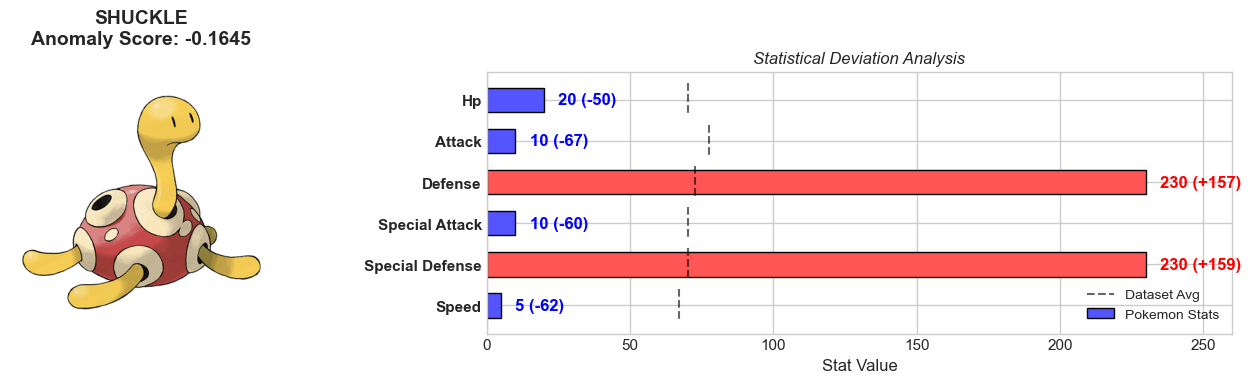

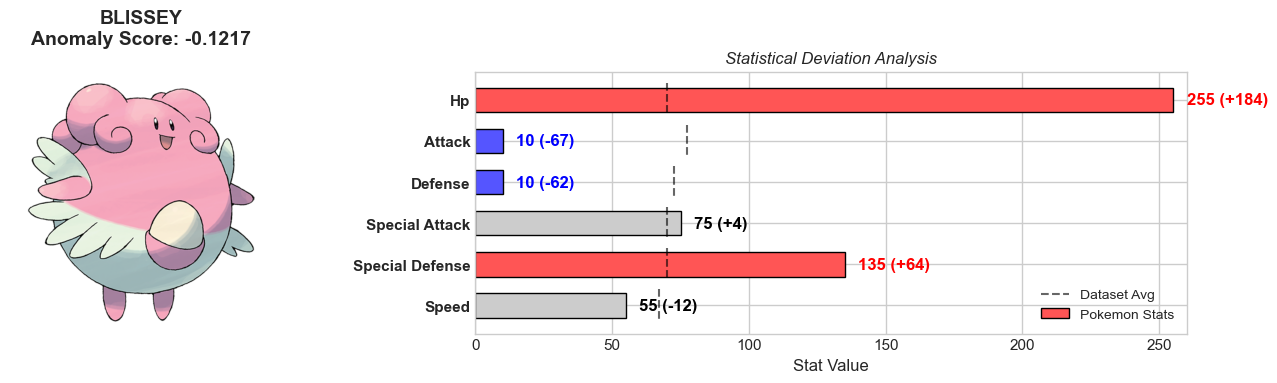

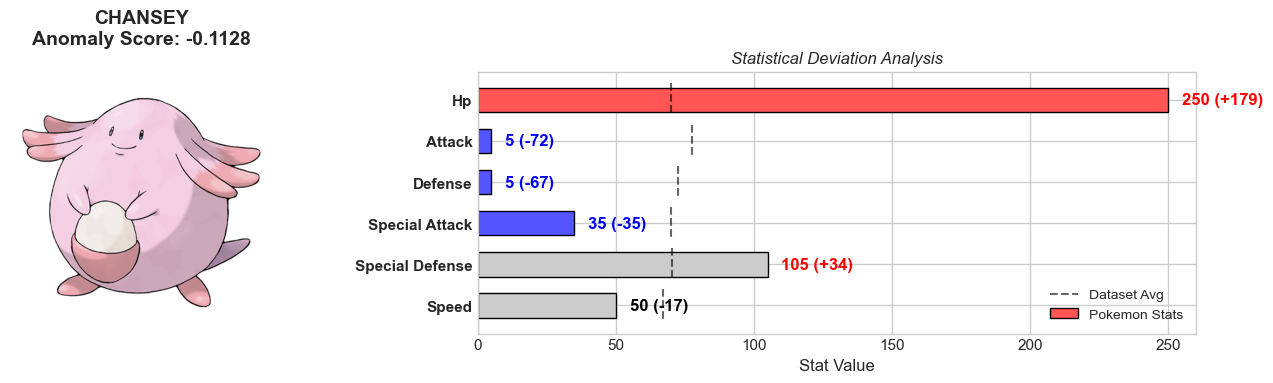

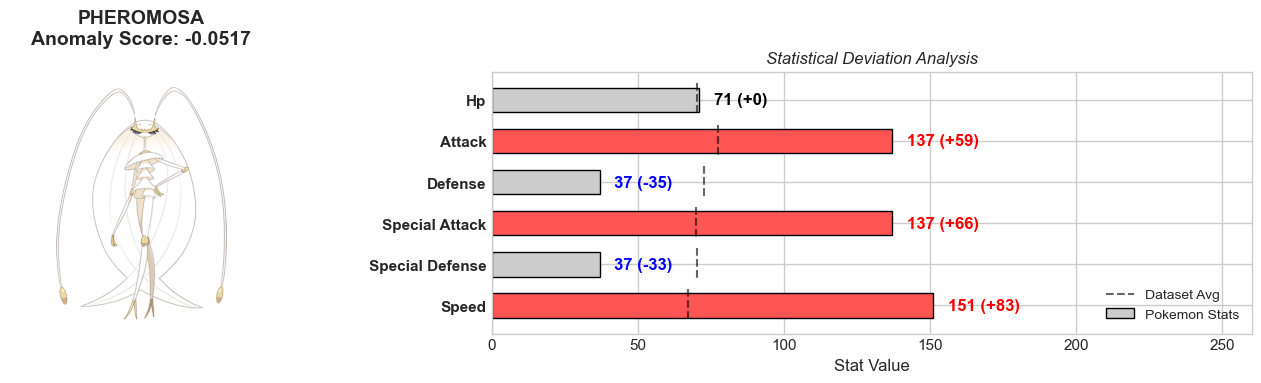

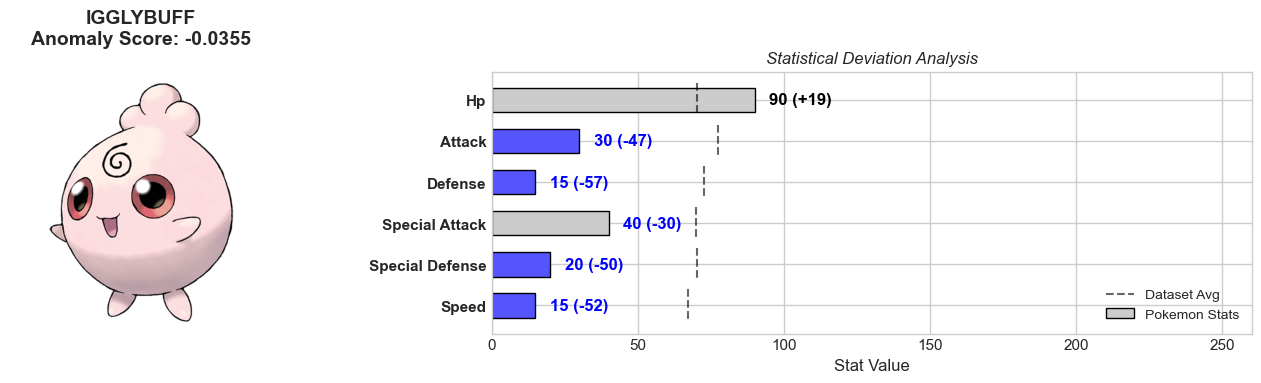

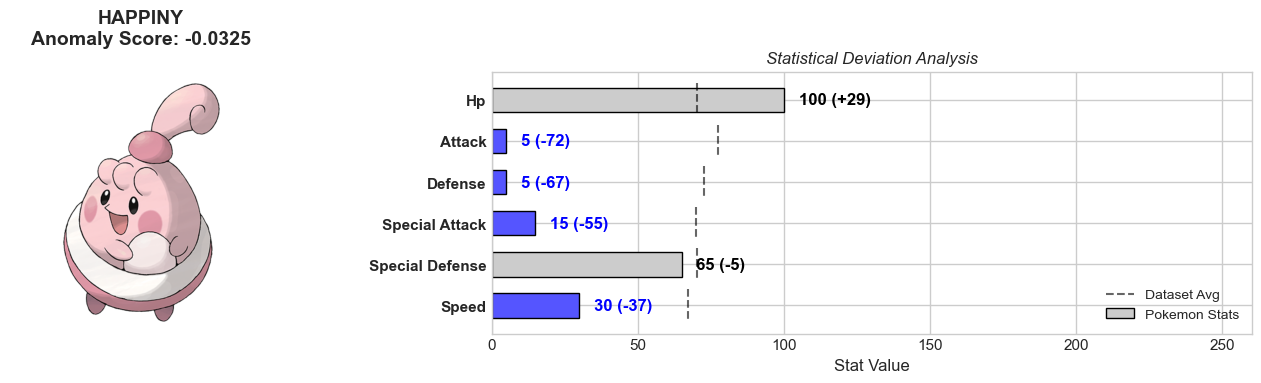

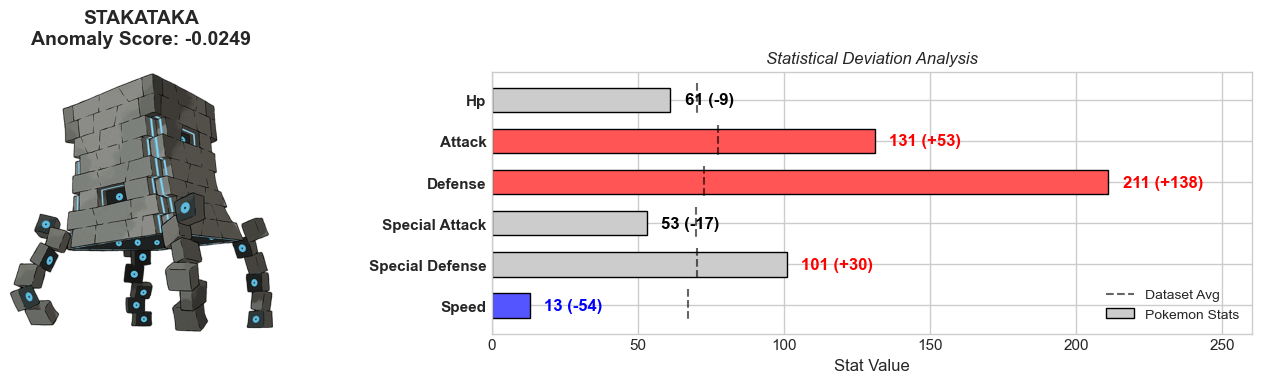

In [59]:
import requests
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as PILImage
from io import BytesIO

def get_pokemon_img(name):
    try:
        name_clean = name.lower().replace(" ", "-").replace(".", "").replace("'", "")
        url = f"https://pokeapi.co/api/v2/pokemon/{name_clean}"
        response = requests.get(url, timeout=5).json()
        img_url = response['sprites']['other']['official-artwork']['front_default']
        return PILImage.open(BytesIO(requests.get(img_url).content))
    except:
        return None

dataset_mean = pokemon_df[stats_cols].mean()
top_anomalies = pokemon_df.sort_values('anomaly_score').head(10)

for i, (index, row) in enumerate(top_anomalies.iterrows()):
    p_name = row['name']
    
    fig = plt.figure(figsize=(14, 4))
    gs = fig.add_gridspec(1, 2, width_ratios=[1, 1.5])
    ax_img = fig.add_subplot(gs[0])
    ax_stats = fig.add_subplot(gs[1])
    
    # 1. Pokemon Image and Title
    img = get_pokemon_img(p_name)
    if img:
        ax_img.imshow(img)
    ax_img.set_title(f"{p_name.upper()}\nAnomaly Score: {row['anomaly_score']:.4f}", 
                     fontsize=14, fontweight='bold', pad=20)
    ax_img.axis('off')
    
    # 2. Stats Bar Chart with Deviation Coloring
    y_pos = np.arange(len(stats_cols))
    colors = []
    for col in stats_cols:
        val = row[col]
        mean = dataset_mean[col]
        if val > mean * 1.5: colors.append('#ff5555') # Strongly above average
        elif val < mean * 0.5: colors.append('#5555ff') # Strongly below average
        else: colors.append('#cccccc') # Near average
    
    bars = ax_stats.barh(y_pos, row[stats_cols], color=colors, edgecolor='black', height=0.6, label='Pokemon Stats')
    
    ax_stats.vlines(dataset_mean.values, y_pos-0.4, y_pos+0.4, color='black', 
                    linestyle='--', alpha=0.6, label='Dataset Avg')
    
    ax_stats.set_yticks(y_pos)
    ax_stats.set_yticklabels([c.replace('-', ' ').title() for c in stats_cols], fontweight='bold')
    ax_stats.set_xlim(0, 260) 
    ax_stats.set_xlabel('Stat Value')
    ax_stats.invert_yaxis()
    
    for j, bar in enumerate(bars):
        width = bar.get_width()
        diff = width - dataset_mean.iloc[j]
        label_color = 'red' if diff > 30 else ('blue' if diff < -30 else 'black')
        ax_stats.text(width + 5, bar.get_y() + bar.get_height()/2, 
                      f'{int(width)} ({"+" if diff>0 else ""}{int(diff)})', 
                      va='center', fontweight='bold', color=label_color)

    ax_stats.legend(loc='lower right', fontsize='small')
    ax_stats.set_title("Statistical Deviation Analysis", fontsize=12, style='italic')
    
    plt.tight_layout()
    plt.show()

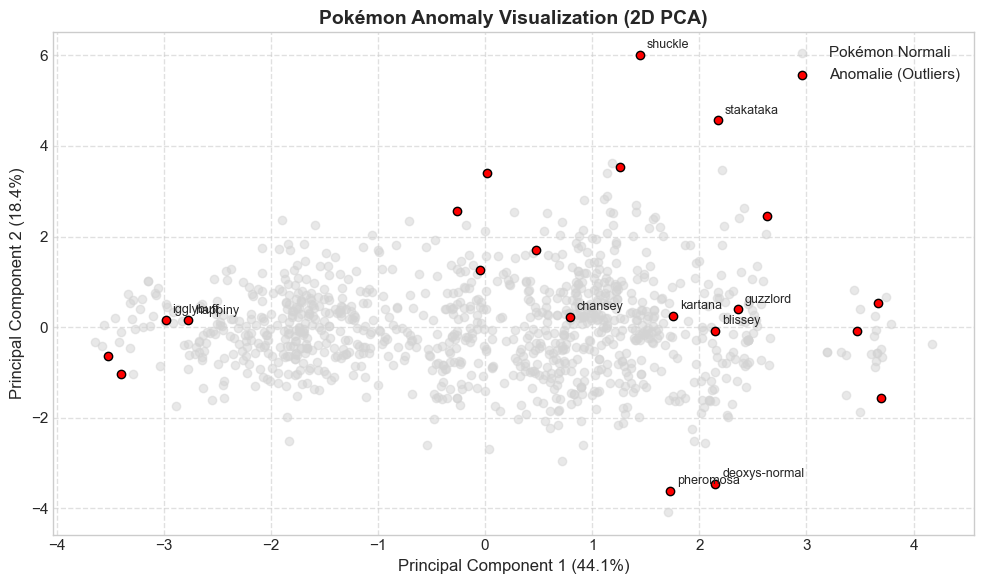

In [45]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd

# Dimensionality reduction using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pokemon_df['pca_1'] = X_pca[:, 0]
pokemon_df['pca_2'] = X_pca[:, 1]

plt.figure(figsize=(10, 6))

normal = pokemon_df[pokemon_df['anomaly'] == 1]
plt.scatter(normal['pca_1'], normal['pca_2'], c='lightgray', label='Pokémon Normali', alpha=0.5)

anomalies = pokemon_df[pokemon_df['anomaly'] == -1]
plt.scatter(anomalies['pca_1'], anomalies['pca_2'], c='red', label='Anomalie (Outliers)', edgecolors='black')

top_10 = pokemon_df.sort_values('anomaly_score').head(10)
for i, row in top_10.iterrows():
    plt.annotate(row['name'], (row['pca_1'], row['pca_2']), xytext=(5,5), textcoords='offset points', fontsize=9)

plt.title('Pokémon Anomaly Visualization (2D PCA)', fontsize=14, fontweight='bold')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#### **What makes these Pokémon unusual?** ####
Most anomalies are caused by **extreme stats** rather than rare combinations.
- **Shuckle:** Has an extremely high defense (230) but nearly non-existent hp (20), attack (10), and speed (5).
- **Blissey & Chansey:** They possess extreme hp (255 and 250) but have virtually no physical attack or defense (5–10).
- **Kartana & Deoxys** stand out for theri extremely high attack and speed.

#### **Do the anomalies belong to specific types or are they spread?** ####
Anomalies appear across many different types, not just one.
They include Bug, Normal, Psychic, Grass, Dark, and Rock types.
However, the **Normal type** appears often, mainly because some Normal Pokémon (like Blissey and Chansey) are designed with very high HP and low defensive balance.

#### **Are Legendary/Mythical Pokémon more likely to be outliers?** ####

Yes, Legendary and Mythical Pokémon (like Deoxys, Pheromosa, Kartana) are significantly more likely to be outliers.
- They usually have much higher total stats than normal Pokémon.
- They are often designed with very extreme strenghts and weaknesses.

#### **Are there Pokémon that are unusual or do not fit well with the others?** ####
Yes, some Pokémon are unusual because their base stats are very different from most others.
They mainly belong to two groups:
- **Specialists (extreme stats):** These Pokémon have one very high stat and very low others.
For example, Shuckle has extremely high Defense, while Blissey and Chansey have extremely high HP but weak defenses.
- **Power outliers:** Legendary, Mythical, and Ultra Beast Pokémon (such as Deoxys, Kartana, and Pheromosa) are also unusual because they have very high Attack and Speed compared to normal Pokémon.

## **Part 6: Building a Balanced Pokémon Team**

A **balanced team of six Pokémon** is defined as one that combines **statistical strength**, **role complementarity**, and **elemental coverage**, while remaining easy to interpret.

Specifically, a balanced team should:

1. **Ensure type diversity**, avoiding repeated primary types in order to reduce shared weaknesses.

2. **Cover complementary combat roles**, including:
   - At least one **defensive tank** (high HP and defensive stats),
   - At least one **fast Pokémon** (high Speed),
   - At least one **physical attacker** (high Attack),
   - At least one **special attacker** (high Special Attack).

3. **Provide elemental coverage** based on simplified Pokémon battle rules  
   (e.g., *Water > Fire*, *Fire > Grass*, *Grass > Water*), ensuring that the team can counter a wide range of opposing types without explicitly modeling the full battle system.

4. **Rely on above-average Pokémon**, in terms of total base statistics, to ensure overall team strength.

### **6.1 Selection Procedure**

To construct such a team:

- Pokémon were first filtered to retain only those whose total base stats exceed the dataset average.
- A greedy selection procedure was then applied to select Pokémon excelling in defensive, offensive, and speed-oriented roles, while avoiding repetition of primary types.
- During selection, preference was given to Pokémon that increased the team’s **type-effectiveness coverage**, based on a simplified type-counter mapping.
- The remaining slots were filled by Pokémon with high overall strength, maximizing both statistical balance and elemental coverage.

This approach yields a team that is **statistically strong**, **role-balanced**, and **robust to different battle matchups**, while remaining transparent and easy to justify.


In [46]:
# 1. Feature Engineering
stat_cols = ['hp', 'attack', 'defense', 'special-attack', 'special-defense', 'speed']
pokemon_df['total_stats'] = pokemon_df[stat_cols].sum(axis=1)

# threshold
avg_stats = pokemon_df[stat_cols].mean()
avg_total_stats = pokemon_df['total_stats'].mean()

print(f"Threshold: {avg_total_stats:.2f}")

# 2. Define simple role scores
pokemon_df['tank_score'] = pokemon_df['hp'] + pokemon_df['defense'] + pokemon_df['special-defense']
pokemon_df['physical_attacker_score'] = pokemon_df['attack']
pokemon_df['special_attacker_score'] = pokemon_df['special-attack']
pokemon_df['speed_score'] = pokemon_df['speed']

# 3. Define a simplified type-effectiveness rules
type_counters = {
    'fire': ['grass', 'ice', 'bug', 'steel'],
    'water': ['fire', 'ground', 'rock'],
    'grass': ['water', 'ground', 'rock'],
    'electric': ['water', 'flying'],
    'ground': ['electric', 'fire', 'rock', 'steel'],
    'fighting': ['normal', 'rock', 'steel', 'ice'],
    'psychic': ['fighting', 'poison'],
    'ice': ['grass', 'ground', 'flying'],
    'dark': ['psychic', 'ghost']
}

pokemon_df['coverage_score'] = pokemon_df['type_1'].apply(
    lambda t: len(type_counters.get(t, []))
)

# Combined score: strength + coverage
pokemon_df['balanced_score'] = (
    0.6 * pokemon_df['total_stats'] +
    0.4 * pokemon_df['coverage_score'] * 100
)

# 3. Filter to strong pokémon only
strong_pokemon = pokemon_df[pokemon_df['total_stats'] > avg_total_stats].copy()

# 4. Greedy selection procedure (roles + type coverage)
selected_team = []
used_types = set()
covered_enemy_types = set()

def select_pokemon(df, score_col):
    for _, row in df.sort_values(score_col, ascending=False).iterrows():
        if row['type_1'] in used_types:
            continue
        
        new_coverage = set(type_counters.get(row['type_1'], []))
        if not new_coverage.issubset(covered_enemy_types):
            selected_team.append(row)
            used_types.add(row['type_1'])
            covered_enemy_types.update(new_coverage)
            break

select_pokemon(strong_pokemon, 'tank_score')
select_pokemon(strong_pokemon, 'speed_score')
select_pokemon(strong_pokemon, 'physical_attacker_score')
select_pokemon(strong_pokemon, 'special_attacker_score')

# 5. Fill remaining slots by balanced score, keeping type diversity and coverage
for _, row in strong_pokemon.sort_values('balanced_score', ascending=False).iterrows():
    if len(selected_team) == 6:
        break
    if row['type_1'] not in used_types:
        selected_team.append(row)
        used_types.add(row['type_1'])
        covered_enemy_types.update(type_counters.get(row['type_1'], []))

balanced_team = pd.DataFrame(selected_team)[
    ['pokemon_id', 'name', 'type_1', 'total_stats',
     'hp', 'attack', 'defense', 'special-attack', 'special-defense', 'speed',
     'coverage_score']
]

Threshold: 427.69


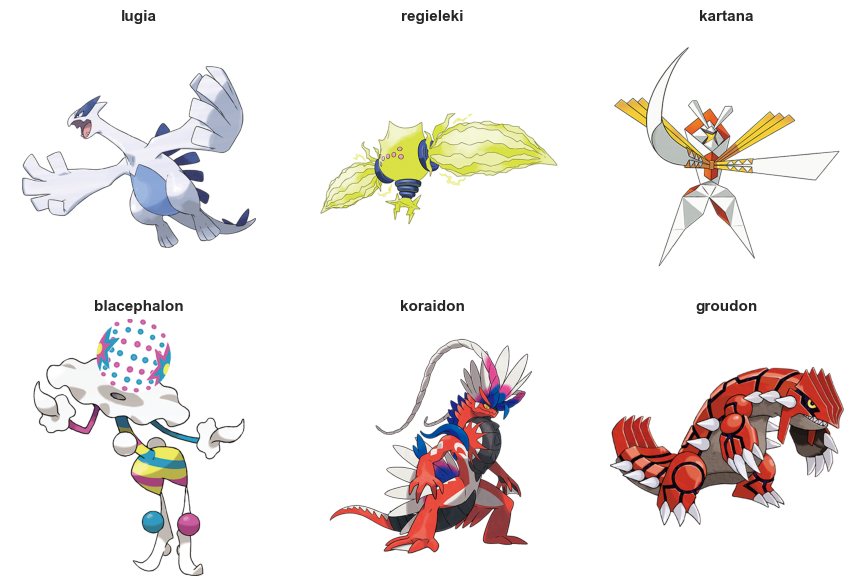

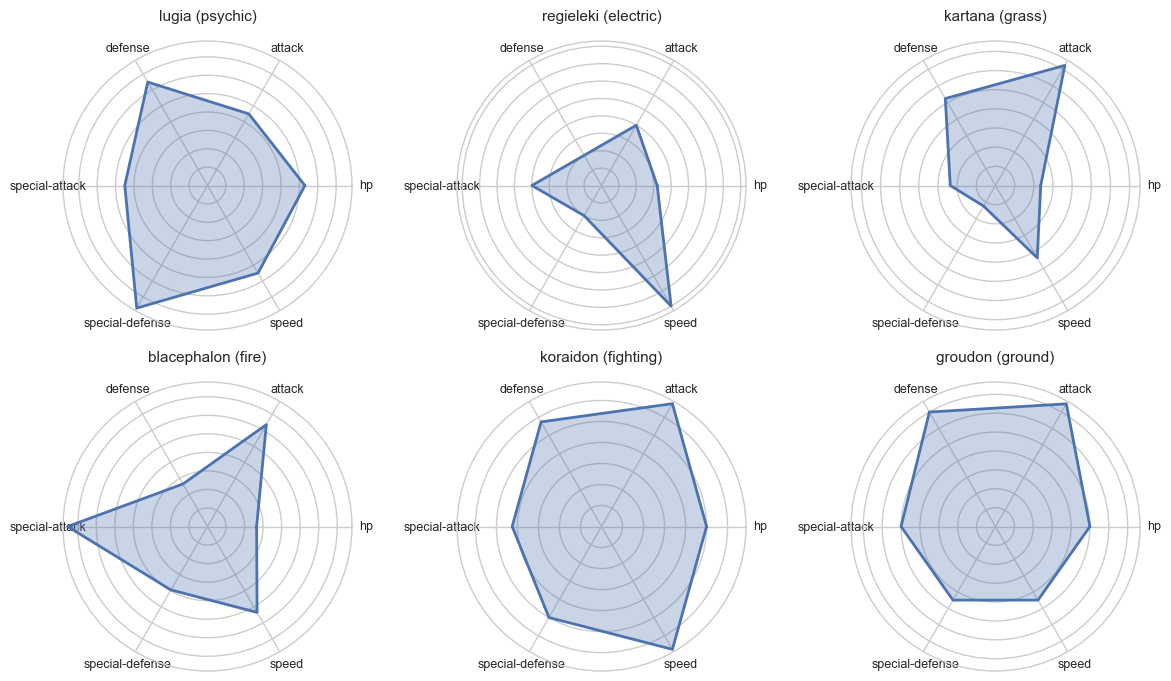

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import requests
from io import BytesIO

# ----------------------------
# Radar setup
# ----------------------------
stats = ['hp', 'attack', 'defense', 'special-attack', 'special-defense', 'speed']
angles = np.linspace(0, 2 * np.pi, len(stats), endpoint=False).tolist()
angles += angles[:1]  # close radar

# ----------------------------
# 1. Images (3x2)
# ----------------------------
fig, axes = plt.subplots(2, 3, figsize=(9, 6), dpi=100)
fig.patch.set_facecolor("white")

for ax, (_, row) in zip(axes.flatten(), balanced_team.iterrows()):
    url = f"https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/other/official-artwork/{row['pokemon_id']}.png"
    img = Image.open(BytesIO(requests.get(url).content)).convert("RGBA")
    ax.imshow(img)
    ax.set_title(row['name'], fontsize=11, fontweight="bold")
    ax.axis("off")
    ax.set_facecolor("white")

plt.tight_layout()
plt.show()

# ----------------------------
# 2. Radar charts (3x2)
# ----------------------------
fig, axes = plt.subplots(2, 3, figsize=(12, 7), dpi=100, subplot_kw=dict(polar=True))
fig.patch.set_facecolor("white")

for ax, (_, row) in zip(axes.flatten(), balanced_team.iterrows()):
    values = row[stats].tolist()
    values += values[:1]

    ax.plot(angles, values, linewidth=2)
    ax.fill(angles, values, alpha=0.3)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(stats, fontsize=9)

    # Remove radial numbers for a clean Pokédex look
    ax.set_yticklabels([])

    ax.set_title(f"{row['name']} ({row['type_1']})", fontsize=11, pad=15)

plt.tight_layout()
plt.show()

### **6.2 Team Interpretation**

- **Lugia** (*Psychic*):
    A legendary defensive Pokémon, Lugia exhibits extremely high defensive and special defensive stats, making it an ideal tank capable of absorbing sustained damage while remaining versatile.

- **Regieleki** (*Electric*):
    With unmatched Speed, Regieleki acts as a hyper-fast attacker, excelling at outspeeding virtually any opponent and applying immediate offensive pressure despite limited bulk.

- **Kartana** (*Grass*):
    Kartana is an extreme physical glass cannon, boasting extraordinarily high Attack and Defense but very low HP and Special Defense, making it devastating offensively yet fragile against special attacks.

- **Blacephalon** (*Fire*):
    A classic special attacker, Blacephalon combines very high Special Attack with good Speed, allowing it to function as a high-risk, high-reward offensive threat.

- **Groudon** (*Ground*):
    Groudon provides physical bulk and raw power, with high HP, Attack, and Defense, serving as a second tanky presence while offering strong type coverage against Electric, Fire, and Rock types.

- **Koraidon** (*Fighting*):
    Koraidon is a well-rounded offensive hybrid, combining high Speed and Attack with solid bulk, making it effective in both initiating attacks and sustaining combat.

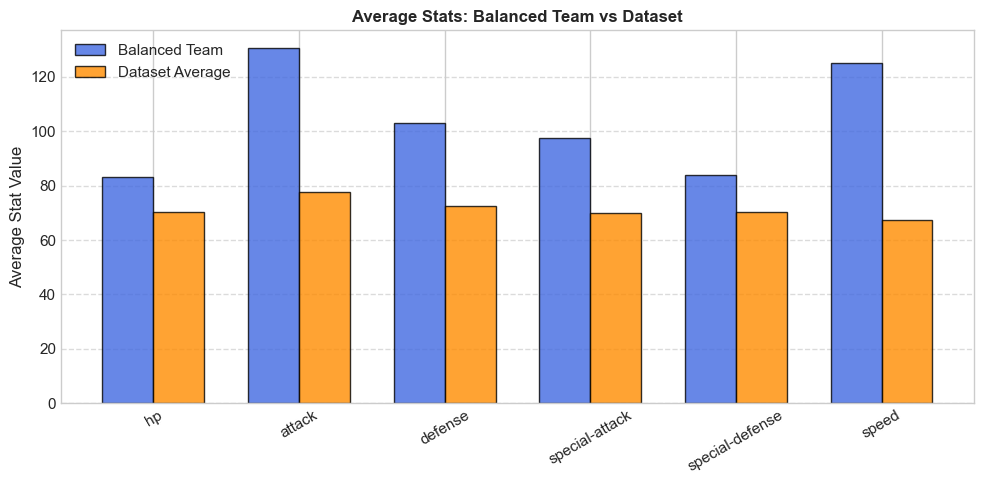

In [ ]:
team_avg = balanced_team[stat_cols].mean()
dataset_avg = pokemon_df[stat_cols].mean()

x = np.arange(len(stat_cols))
width = 0.35

plt.figure(figsize=(10, 5))

plt.bar(x - width/2, team_avg, width, label='Balanced Team', color='royalblue', edgecolor='black', alpha=0.8)
plt.bar(x + width/2, dataset_avg, width, label='Dataset Average', color='darkorange', edgecolor='black', alpha=0.8)

plt.xticks(x, stat_cols, rotation=30)
plt.ylabel('Average Stat Value')
plt.title('Average Stats: Balanced Team vs Dataset', fontweight='bold')
plt.legend()

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
